In [121]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

**Util function for feature embeddings**

In [165]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [166]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'conditioning_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 128}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["clusters"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [167]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_dentategyrus_whole_genome/64dcba3b-e80a-4150-8cc8-63562c569088/checkpoints/last.ckpt"

In [168]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [169]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5
                        }

In [170]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_dentategyrus_whole_genome/8453d1a7-9314-4a7b-a771-9ef6d280cf06/checkpoints/last.ckpt")
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_dentategyrus_whole_genome_no_size_factor/2631b6f3-d6f9-4edd-8f48-3ced47615a3a/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [171]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.2596,  0.2799, -0.0837,  ...,  0.3193, -0.8424, -0.8123],
        [ 0.4245, -0.0654,  0.6183,  ...,  2.0082, -1.0186,  0.8988],
        [-0.4324, -0.5253, -0.1055,  ...,  0.6410,  0.4028,  1.2345],
        ...,
        [-0.8528, -0.1581, -0.7986,  ..., -0.9885, -0.4633, -2.0079],
        [-0.3412, -0.4802,  0.5975,  ..., -1.5017,  0.0226, -0.2268],
        [-1.0471, -1.1799, -0.1420,  ..., -0.8519,  1.2171,  2.0952]],
       device='cuda:0', requires_grad=True)


Initializations

In [173]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17002, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
         

## Read original data 

In [174]:
adata_original = sc.read_h5ad(data_path)
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

## Generate and save cells

In [178]:
num_indices = 18000
index_range = len(adata_original)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_str =  list(adata_indices.obs.clusters)
classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes_str])
# classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes])

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
# log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1)))

In [179]:
X_generated = generative_model.batched_sample(batch_size=180,
                                                repetitions=100,
                                                n_sample_steps=2, 
                                                covariate="clusters", 
                                                covariate_indices=classes, 
                                                log_size_factor=None)

X_generated = X_generated.to("cpu")

### Generate single condition

In [113]:
# dataset.id2cov["clusters"]

In [114]:
# # Pick condition 
# condition_name = "GlialProg"
# condition_val = dataset.id2cov["clusters"][condition_name]
# adata_cond = adata_original[adata_original.obs.clusters==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [115]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="clusters", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=None)

# X_generated = X_generated.to("cpu")

## Preprocess and dump generated data

In [182]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["clusters"] = classes_str
adata_generated.obs["clusters"] = adata_generated.obs["clusters"].astype("category")
adata_generated.layers["X_counts"] = adata_generated.X.copy()

In [183]:
sc.pp.normalize_total(adata_generated, target_sum=10000)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


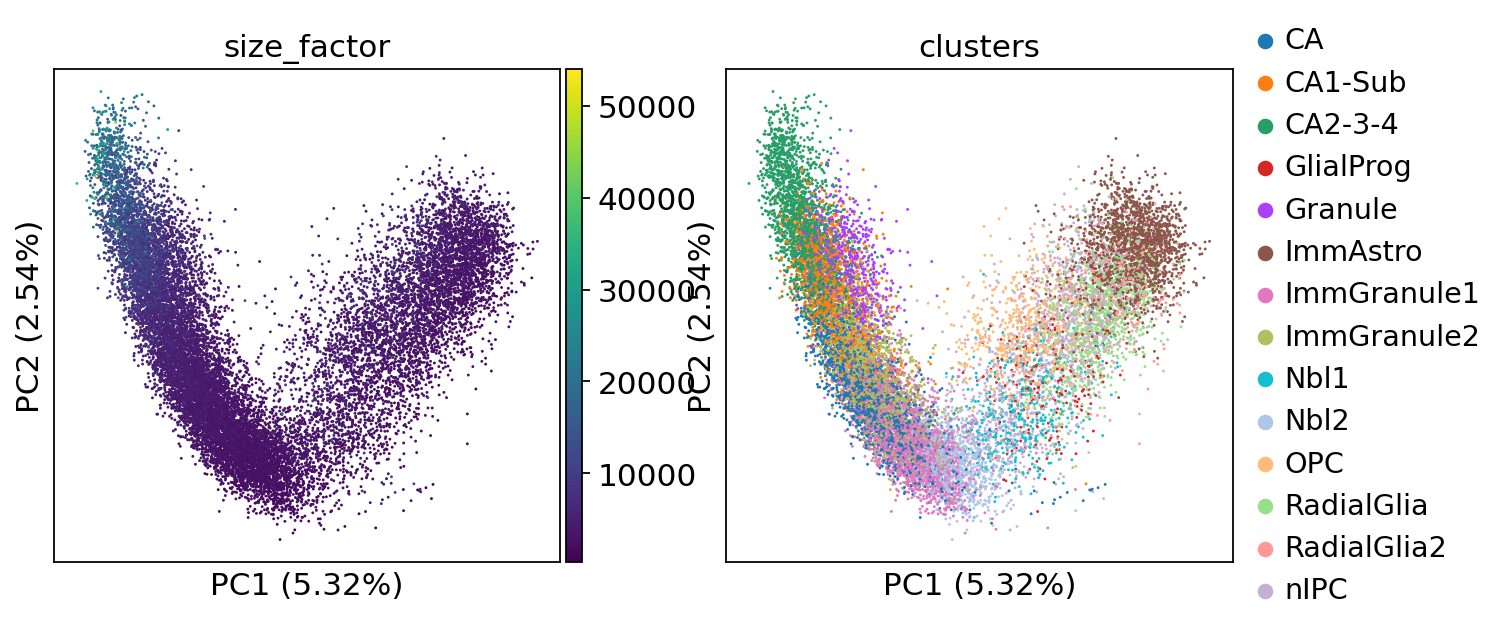

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


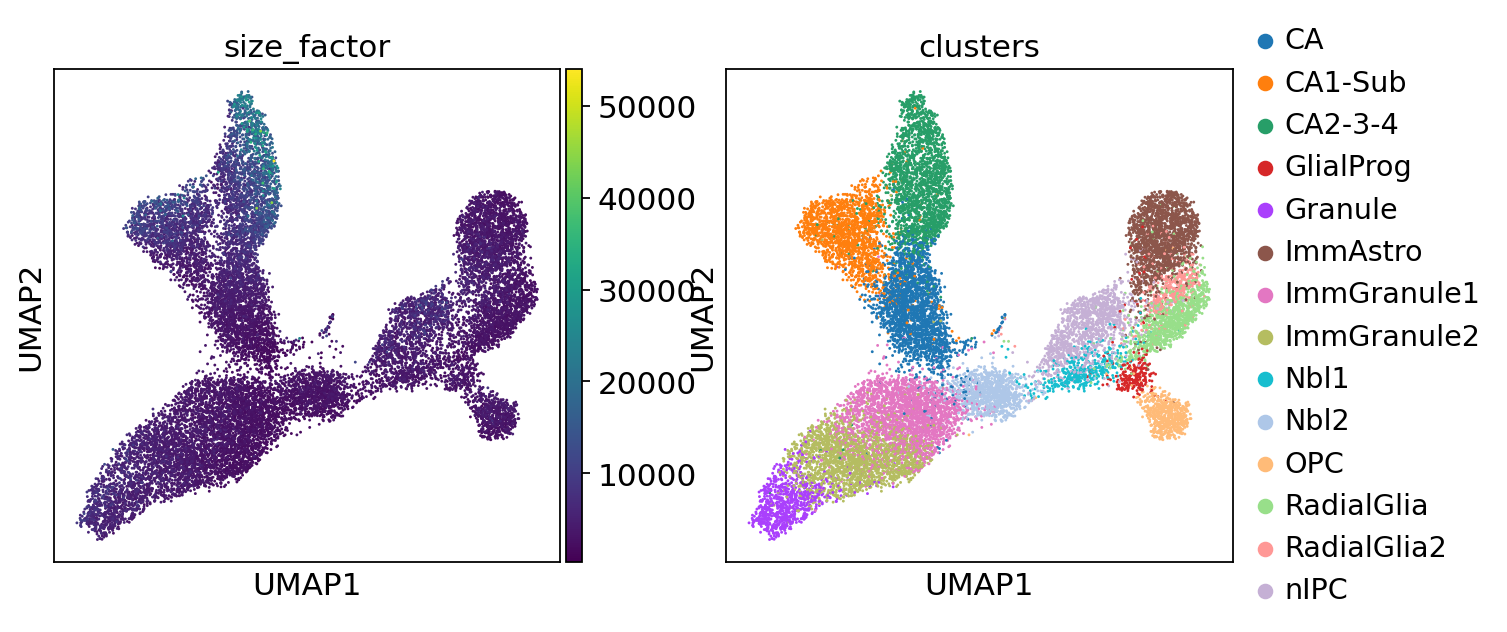

In [184]:
sc.pl.pca(adata_generated, color=["size_factor", "clusters"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "clusters"])

In [190]:
# adata_generated.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/dentategyrus.h5ad")

## Preprocess real data object

In [187]:
sc.pp.normalize_total(adata_original, target_sum=10000)
sc.pp.log1p(adata_original)
sc.tl.pca(adata_original)
sc.pp.neighbors(adata_original)
sc.tl.umap(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


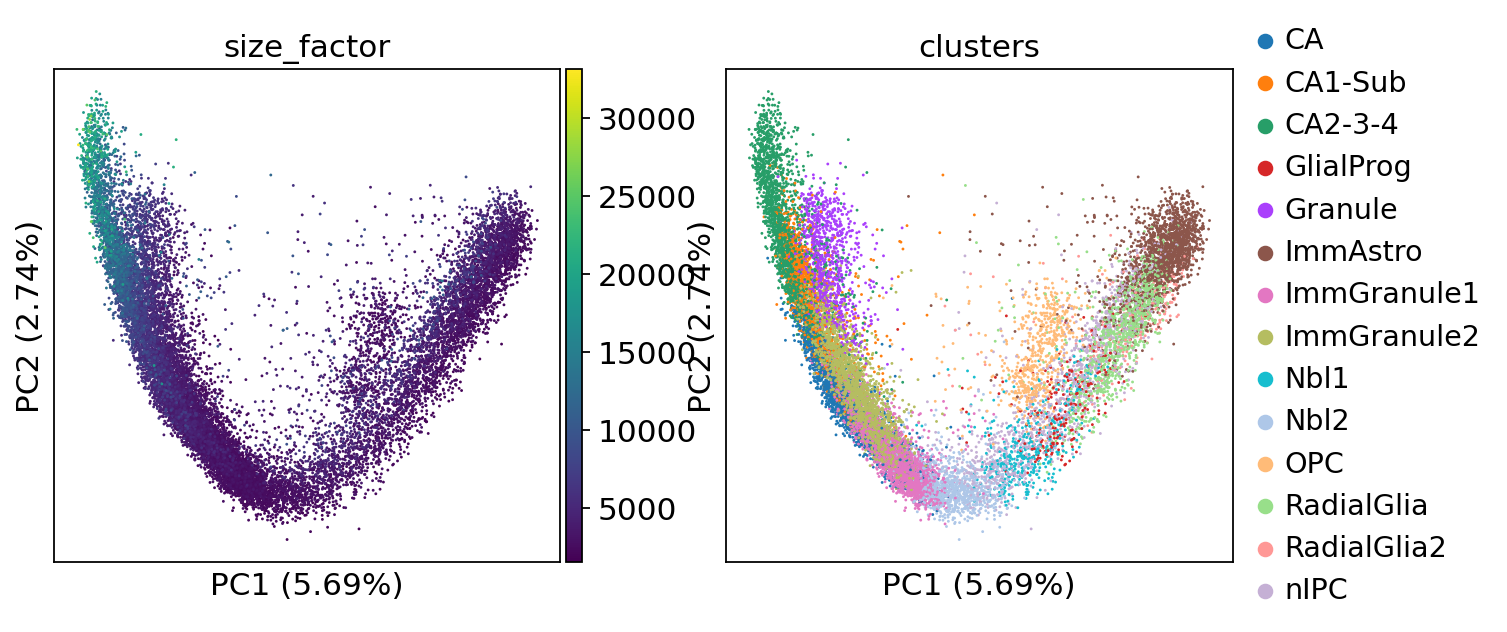

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


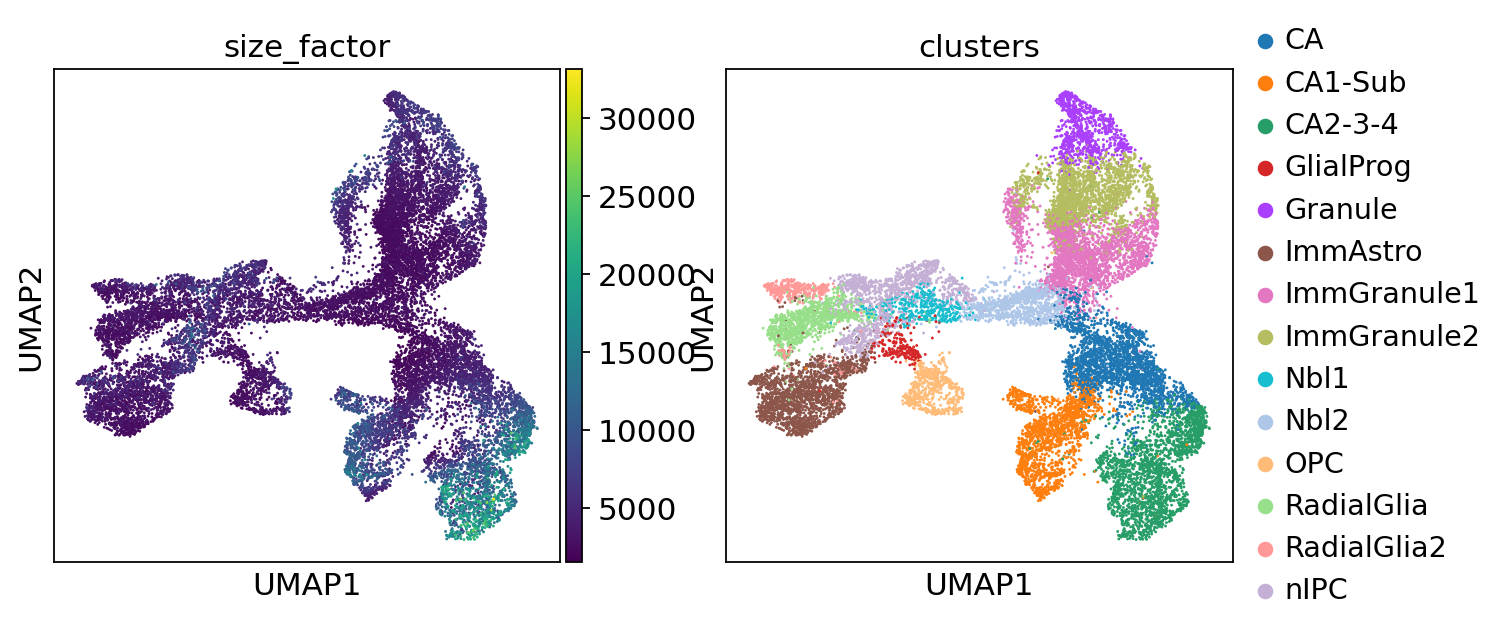

In [188]:
sc.pl.pca(adata_original, color=["size_factor", "clusters"], annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "clusters"])

## Merge and plot the generated and real data

In [191]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["clusters"] = list(adata_original.obs.clusters)+list(classes_str)

In [192]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [193]:
sc.pp.log1p(adata_merged)
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


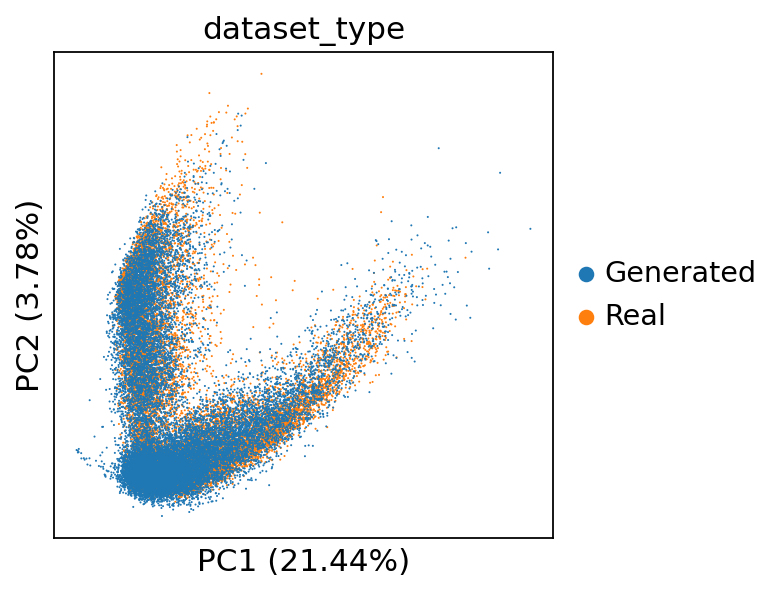

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

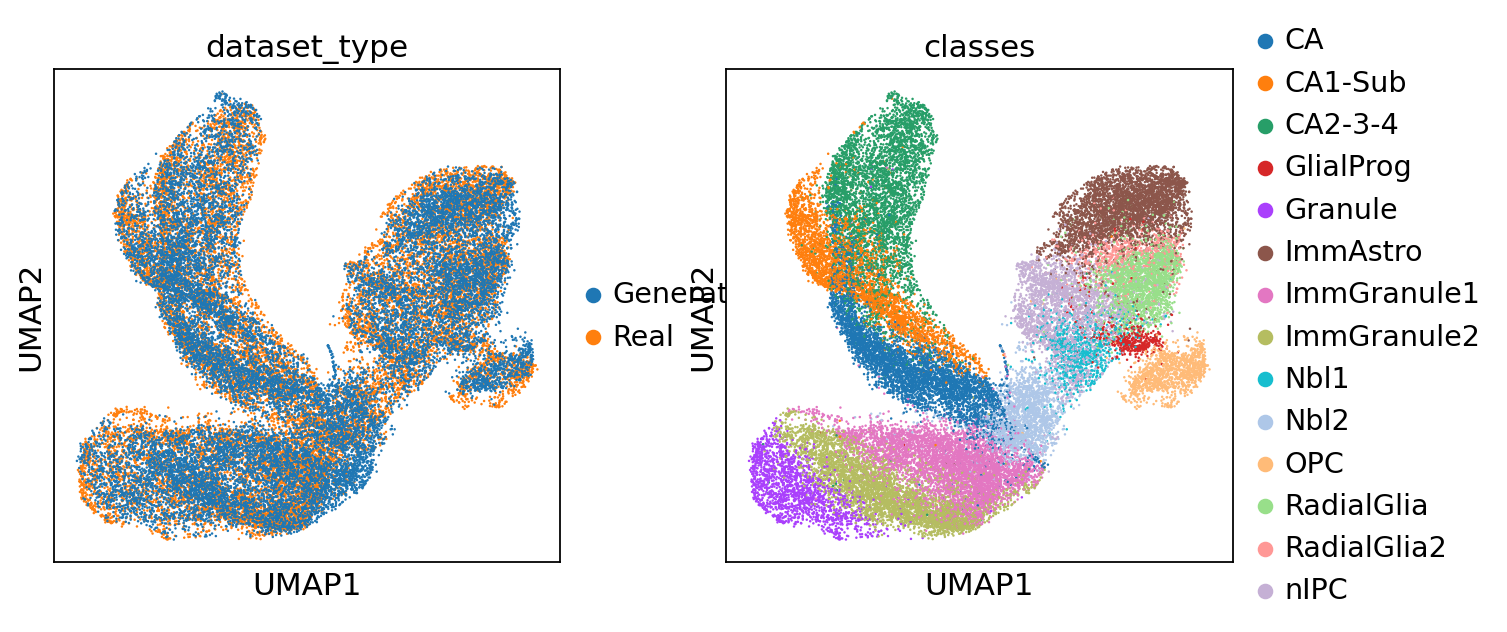

In [194]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["dataset_type", "clusters"], s=5)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


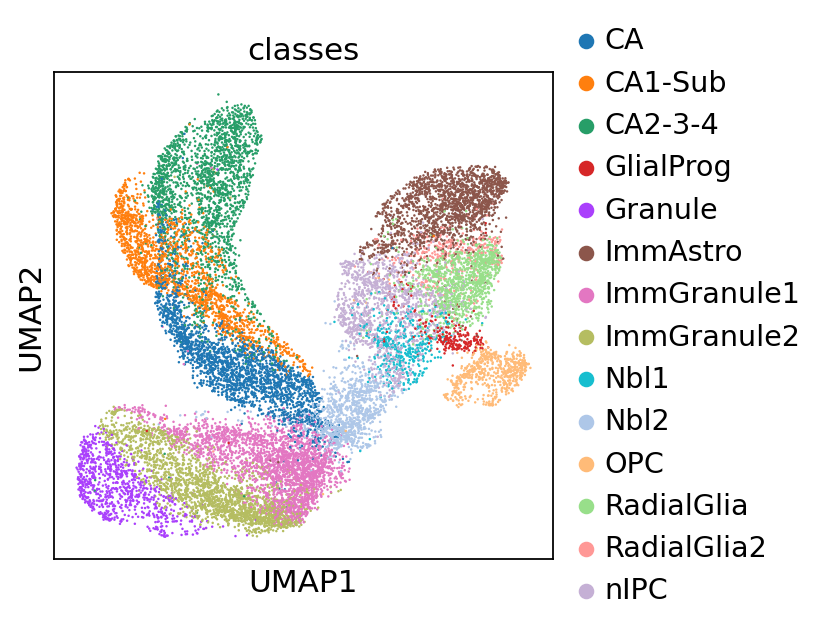

In [195]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"], s=5)

In [196]:
adata_merged.var = adata_original.var

## Markers

In [197]:
ct_to_plot = "ImmAstro"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


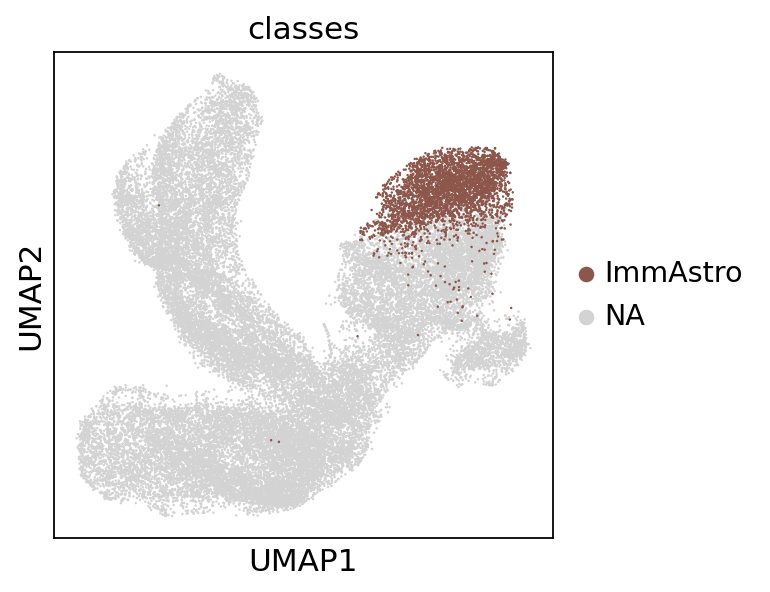

In [198]:
sc.pl.umap(adata_merged, groups=ct_to_plot, color=["classes"], s=5)

In [199]:
marker_genes = ['Aqp4']

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandr

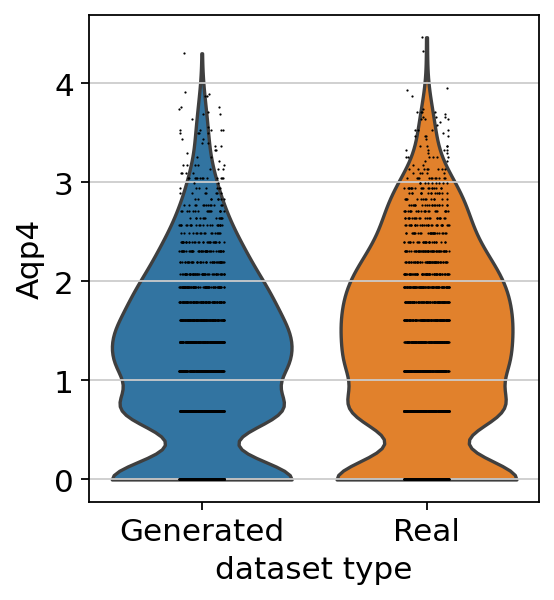

In [200]:
import scanpy as sc

# Assuming adata_merged is your AnnData object
sc.settings.set_figure_params(figsize=(4, 4))  # Set the figsize parameter to make the plot smaller

# Plot the violin plot
sc.pl.violin(adata_merged[adata_merged.obs.classes == ct_to_plot], groupby="dataset_type", keys=marker_genes)

## Saprsity

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498:

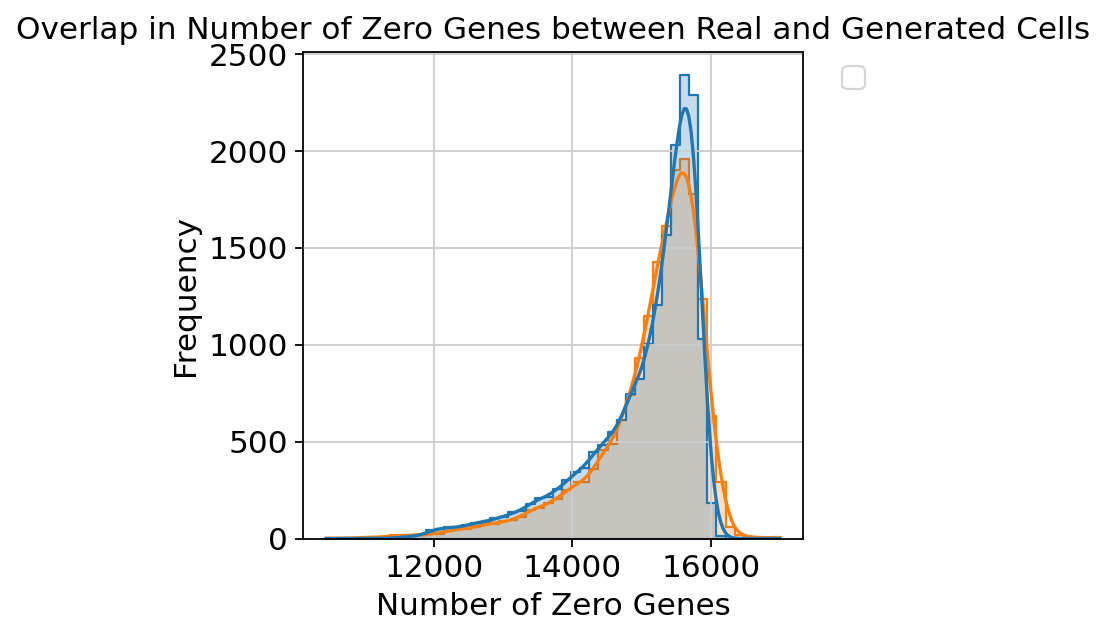

In [201]:
# Separate the number of zero genes for real and generated cells
import seaborn as sns

real_cells_zeros = list((adata_original.X.A==0).sum(1))
generated_cells_zeros = list((adata_generated.X.A==0).sum(1))

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({
    'Number of zeros per cell': real_cells_zeros+generated_cells_zeros,
    'Dataset type': ["Real" for _ in range(len(real_cells_zeros))] + ["Generated" for _ in range(len(generated_cells_zeros))]
})

# Plot histogram using Seaborn
plt.figure(figsize=(4, 4))
sns.histplot(data=df, x='Number of zeros per cell', hue='Dataset type', element='step', bins=50, kde=True)
plt.xlabel('Number of Zero Genes')
plt.ylabel('Frequency')
plt.title('Overlap in Number of Zero Genes between Real and Generated Cells')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Overdispersion

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Figure size 800x480 with 0 Axes>

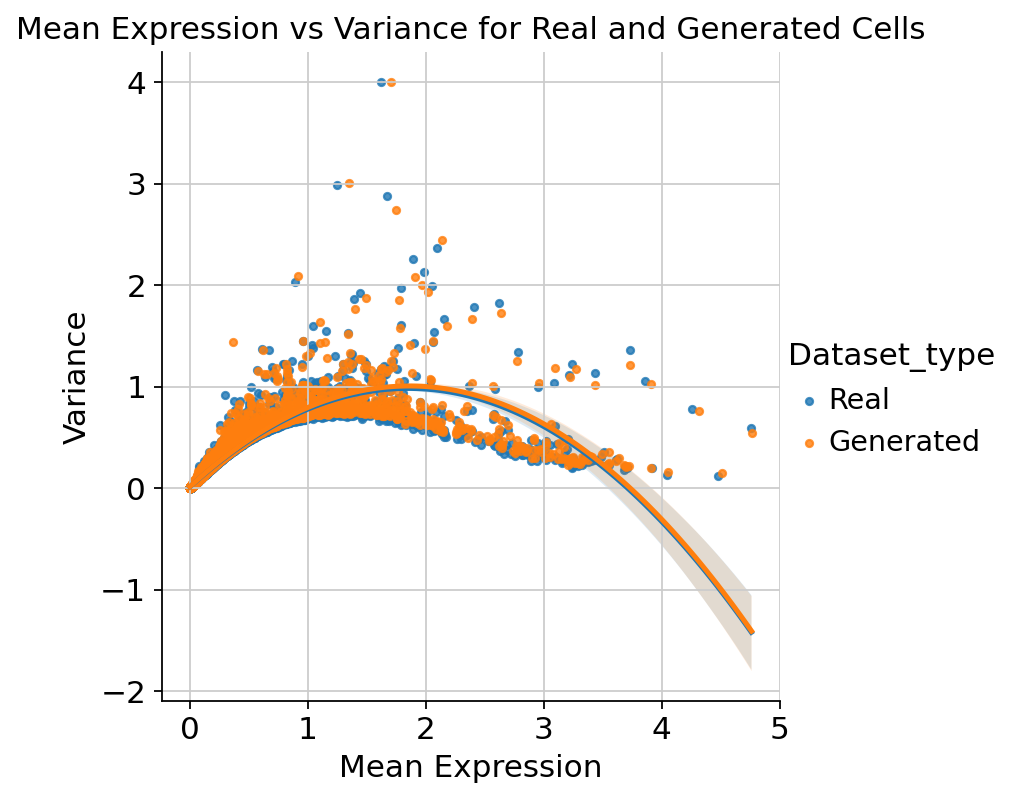

In [202]:
real_cells_mean = list(adata_original.X.A.mean(0))
generated_cells_mean = list(adata_generated.X.A.mean(0))

real_cells_var = list(adata_original.X.A.var(0))
generated_cells_var = list(adata_generated.X.A.var(0))

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({
    'Mean': real_cells_mean+generated_cells_mean,
    'Variance': real_cells_var+generated_cells_var,
    'Dataset_type': ["Real" for _ in range(len(real_cells_mean))] + ["Generated" for _ in range(len(generated_cells_mean))]
})

# Plot histogram using Seaborn
# Plot mean expression vs variance using Seaborn
plt.figure(figsize=(10, 6))
sns.lmplot(data=df, x='Mean', y='Variance', hue='Dataset_type',order=2, scatter_kws={'s': 10})
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.title('Mean Expression vs Variance for Real and Generated Cells')
# plt.legend()
plt.show()